In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Read samples from one station

In [4]:
station_code = 'SONDOC'

#### Read true raw samples

In [5]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [6]:
df.set_index('date', inplace=True)

In [7]:
df = df[df['code'] == station_code]

In [8]:
# How samples distributed
df.groupby(df.index.year).count()

,code,min,max,x,y,cm
date,,,,,,
2002,181,181,181,181,181,181
2003,181,181,181,181,181,181
2004,182,182,182,182,182,182
2005,181,181,181,181,181,181
2006,181,181,181,181,181,181
2007,181,181,181,181,181,181
2008,182,182,182,182,182,182
2009,181,181,181,181,181,181
2010,181,181,181,181,181,181


##### From 2002 to 2010, samples are completed for dry seasons: 181 for normal years; 182 for leap years (January to June)
#### 2011 and 2018 have samples from January to May (151 days)
#### 2012 to 2016 have less samples, missing dates
#### 2017 has no samples at all

#### Reread prepared samples

In [9]:
df = pd.read_csv(f'../../dataset/final/stations/{station_code}.csv', parse_dates=['date'])

In [10]:
# set index to time-series based 'date'
df.set_index('date', inplace=True)

In [11]:
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq=None)

In [12]:
# can not set index frequency to D - daily due to missing discontinuous timestamps in the dataset
df.index.freq = 'D'
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq='D')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6209 entries, 2002-01-01 to 2018-12-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    6209 non-null   object 
 1   min     6209 non-null   float64
 2   max     6209 non-null   float64
dtypes: float64(2), object(1)
memory usage: 194.0+ KB


In [14]:
# sort by date index
df.sort_index(inplace=True)

df.head()

,code,min,max
date,,,
2002-01-01,SONDOC,0.10000,0.30000
2002-01-02,SONDOC,0.10000,0.40000
2002-01-03,SONDOC,0.20000,0.40000
2002-01-04,SONDOC,0.20000,0.50000
2002-01-05,SONDOC,0.10000,0.60000


### ARIMA Self Help

In [15]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

### Split training and test sets  
Use 2002 to 2015 samples for training, 2016 test while using 2018 for evaluation

In [16]:
test_year = 2016

In [17]:
train_df = df[df.index.year < test_year]
train_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='date', length=5113, freq='D')

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,"5,113.00000",1.09981,1.99923,0.01000,0.01000,0.01000,1.50000,12.90000
max,"5,113.00000",2.84172,4.17534,0.01000,0.01000,0.01000,5.20000,25.50000


In [19]:
test_df = df[df.index.year == test_year]
test_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=366, freq='D')

In [20]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,366.00000,3.43527,4.68575,0.01000,0.01000,0.01000,6.10000,14.90000
max,366.00000,6.44730,7.84975,0.01000,0.01000,0.01000,12.58750,27.40000


In [21]:
# January 1 to May 31 without Feb 29
def compact_to_dry_season(data):
    # drop Feb 29
    drop_index = data[(data.index.month == 2) & (data.index.day == 29)].index
    data = data.drop(drop_index)
    
    # drop all dates after May 31
    drop_index = data[data.index.month >= 6].index
    data = data.drop(drop_index)
    
    # convert to RangeIndex
    return data.reset_index()

In [22]:
# Using index instead of time series
train_df = compact_to_dry_season(train_df)

In [23]:
train_df.head()

,date,code,min,max
0,2002-01-01,SONDOC,0.10000,0.30000
1,2002-01-02,SONDOC,0.10000,0.40000
2,2002-01-03,SONDOC,0.20000,0.40000
3,2002-01-04,SONDOC,0.20000,0.50000
4,2002-01-05,SONDOC,0.10000,0.60000


In [24]:
train_df.tail()

,date,code,min,max
2109,2015-05-27,SONDOC,1.00000,6.40000
2110,2015-05-28,SONDOC,1.60000,6.50000
2111,2015-05-29,SONDOC,3.10000,6.00000
2112,2015-05-30,SONDOC,0.01000,0.01000
2113,2015-05-31,SONDOC,0.01000,0.01000


In [25]:
# Using index instead of time series
test_df = compact_to_dry_season(test_df)

In [26]:
# Using index instead of time series: move test_df index after train_df index
test_df.index += len(train_df)

In [27]:
test_df.head()

,date,code,min,max
2114,2016-01-01,SONDOC,0.01000,0.01000
2115,2016-01-02,SONDOC,2.70000,6.90000
2116,2016-01-03,SONDOC,3.70000,6.70000
2117,2016-01-04,SONDOC,5.30000,7.10000
2118,2016-01-05,SONDOC,5.60000,8.16000


In [28]:
test_df.tail()

,date,code,min,max
2260,2016-05-27,SONDOC,1.30000,6.26667
2261,2016-05-28,SONDOC,1.00000,6.63333
2262,2016-05-29,SONDOC,0.70000,7.00000
2263,2016-05-30,SONDOC,0.90000,7.50000
2264,2016-05-31,SONDOC,1.10000,7.60000


### Try out some simpler models

In [29]:
value_field = 'max'

# seasonal adjustment
adjustment = 'additive'
#adjustment = 'multiplicative'

In [30]:
# Annual
season_length = test_df.shape[0]  # same length of test data if using time series

season_length

151

1. Holt-Winters method via Exponential Smoothing

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train_df[value_field], 
                                trend=adjustment, seasonal=adjustment, 
                                seasonal_periods=season_length).fit()

In [32]:
hw_prediction = hw_model.forecast(season_length)

In [33]:
hw_prediction.head(10)

2114   -4.01264
2115   -4.08339
2116   -4.10005
2117   -4.00737
2118   -3.99247
2119   -3.95561
2120   -3.74119
2121   -3.53536
2122   -3.76421
2123   -3.99269
dtype: float64

In [34]:
hw_prediction.tail(10)

2255   1.17617
2256   1.10664
2257   0.81048
2258   1.43602
2259   1.61174
2260   1.45999
2261   1.46444
2262   0.97697
2263   0.69489
2264   0.00702
dtype: float64

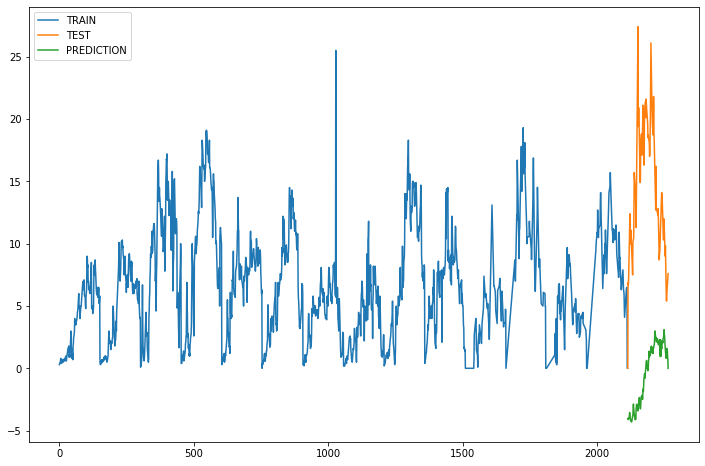

In [35]:
# plot prediction vs. true values
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))
hw_prediction.plot(legend=True, label='PREDICTION');

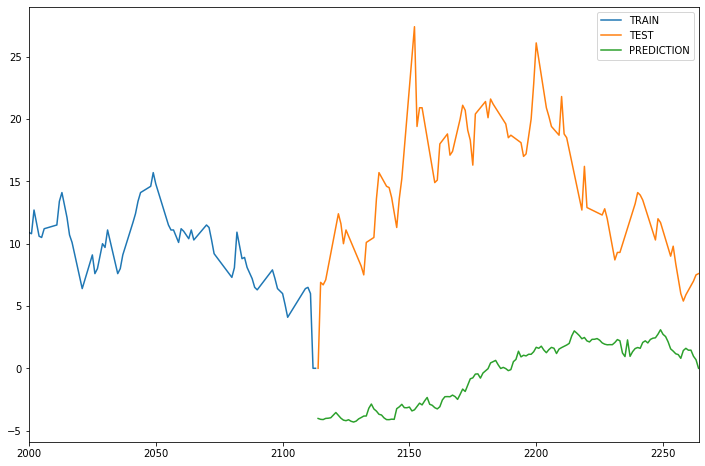

In [36]:
# plot prediction vs. true values on test set (zoomed version)
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))

# when using time series
# hw_prediction.plot(legend=True, label='PREDICTION', xlim=[f'{test_year - 1}-01-01', f'{test_year}-12-31']);

# when using index
hw_prediction.plot(legend=True, label='PREDICTION', xlim=[2000, 2264]);

#### Evaluating Prediction against test set

In [37]:
# Option 1: use scikit-learns implementations
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
test_df[value_field].describe()

count   151.00000
mean     14.75007
std       5.14395
min       0.01000
25%      10.55000
50%      14.50000
75%      18.86667
max      27.40000
Name: max, dtype: float64

In [39]:
hw_prediction.describe()

count   151.00000
mean     -0.46401
std       2.46967
min      -4.29871
25%      -3.09016
50%       0.44107
75%       1.68165
max       3.10182
dtype: float64

1. For using time series: The average of test data value is: 6.45 while the average of prediction value is: 1.97  

2. For using index: The average of test data value is: 14.75 while the average of prediction value is: -0.46

In [40]:
mae = mean_absolute_error(test_df[value_field], hw_prediction)

mae

15.214079357725941

In [41]:
mse = mean_squared_error(test_df[value_field], hw_prediction)

mse

262.8767119734241

In [42]:
rmse = np.sqrt(mse)

rmse

16.213473161954663

##### Holt-Winters prediction is not that bad  on time series
1. Result on time series: rmse = 2.60 vs. test data STD = 7.85: Error in form of RMSE is about 33% of Test STD => GOOD ENOUGH
2. Result on index: rmse = 16.21 vs. test data STD = 5.14 => SO BAD

#### Forecasting future

In [43]:
# construct a full dataset including train and test datasets
full_df = df[df.index.year <= test_year]
full_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=5479, freq='D')

In [44]:
# Using index instead of time series
full_df = compact_to_dry_season(full_df)

In [45]:
full_df.head()

,date,code,min,max
0,2002-01-01,SONDOC,0.10000,0.30000
1,2002-01-02,SONDOC,0.10000,0.40000
2,2002-01-03,SONDOC,0.20000,0.40000
3,2002-01-04,SONDOC,0.20000,0.50000
4,2002-01-05,SONDOC,0.10000,0.60000


In [46]:
full_df.tail()

,date,code,min,max
2260,2016-05-27,SONDOC,1.30000,6.26667
2261,2016-05-28,SONDOC,1.00000,6.63333
2262,2016-05-29,SONDOC,0.70000,7.00000
2263,2016-05-30,SONDOC,0.90000,7.50000
2264,2016-05-31,SONDOC,1.10000,7.60000


In [47]:
# re-train model on the full dataset of the station
hw_final_model = ExponentialSmoothing(full_df[value_field], 
                                      trend=adjustment, 
                                      seasonal=adjustment, 
                                      seasonal_periods=season_length).fit()

In [48]:
# predict for 2017
hw_next_year_forecast = hw_final_model.forecast(season_length)

hw_next_year_forecast.head()

2265   3.78701
2266   3.53234
2267   2.94272
2268   2.84618
2269   2.82637
dtype: float64

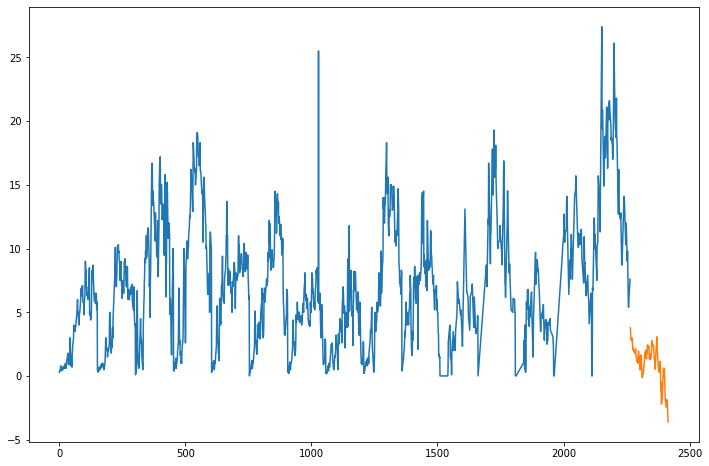

In [49]:
# plot
full_df[value_field].plot(figsize=(12,8))
hw_next_year_forecast.plot();

2. Other simple model goes here

### ARIMA models

1. Using AR component

In [50]:
from statsmodels.tsa.ar_model import AR, ARResults

In [51]:
train_df.head()

,date,code,min,max
0,2002-01-01,SONDOC,0.10000,0.30000
1,2002-01-02,SONDOC,0.10000,0.40000
2,2002-01-03,SONDOC,0.20000,0.40000
3,2002-01-04,SONDOC,0.20000,0.50000
4,2002-01-05,SONDOC,0.10000,0.60000


In [52]:
train_df.tail()

,date,code,min,max
2109,2015-05-27,SONDOC,1.00000,6.40000
2110,2015-05-28,SONDOC,1.60000,6.50000
2111,2015-05-29,SONDOC,3.10000,6.00000
2112,2015-05-30,SONDOC,0.01000,0.01000
2113,2015-05-31,SONDOC,0.01000,0.01000


In [53]:
model = AR(train_df[value_field])

ARfit = model.fit(method='mle', ic='t-stat')

lags = ARfit.k_ar

print(f'Lag: {lags}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 25
Coefficients:
const      0.22007
L1.max     0.88455
L2.max     0.06217
L3.max     0.00191
L4.max    -0.00795
L5.max    -0.01413
L6.max    -0.00902
L7.max     0.00252
L8.max     0.01362
L9.max     0.03489
L10.max   -0.02150
L11.max   -0.01849
L12.max    0.06262
L13.max    0.00517
L14.max    0.01470
L15.max   -0.03221
L16.max    0.04240
L17.max   -0.04144
L18.max    0.00866
L19.max    0.00513
L20.max   -0.03359
L21.max   -0.00773
L22.max    0.03532
L23.max    0.01978
L24.max    0.00539
L25.max   -0.04815
dtype: float64


In [54]:
test_df.head()

,date,code,min,max
2114,2016-01-01,SONDOC,0.01000,0.01000
2115,2016-01-02,SONDOC,2.70000,6.90000
2116,2016-01-03,SONDOC,3.70000,6.70000
2117,2016-01-04,SONDOC,5.30000,7.10000
2118,2016-01-05,SONDOC,5.60000,8.16000


In [55]:
test_df.tail()

,date,code,min,max
2260,2016-05-27,SONDOC,1.30000,6.26667
2261,2016-05-28,SONDOC,1.00000,6.63333
2262,2016-05-29,SONDOC,0.70000,7.00000
2263,2016-05-30,SONDOC,0.90000,7.50000
2264,2016-05-31,SONDOC,1.10000,7.60000


In [56]:
# general formula to calculate time periods for obtaining predictions
start = len(train_df)
end = start + len(test_df) - 1

In [57]:
start

2114

In [58]:
end

2264

In [59]:
ARprediction = ARfit.predict(start=start, end=end).rename(f'AR({lags}) Prediction')

In [60]:
ARprediction.head()

2114   0.16778
2115   0.34245
2116   0.58225
2117   0.94607
2118   1.37856
Name: AR(25) Prediction, dtype: float64

In [61]:
ARprediction.tail()

2260   6.21677
2261   6.21726
2262   6.21771
2263   6.21814
2264   6.21854
Name: AR(25) Prediction, dtype: float64

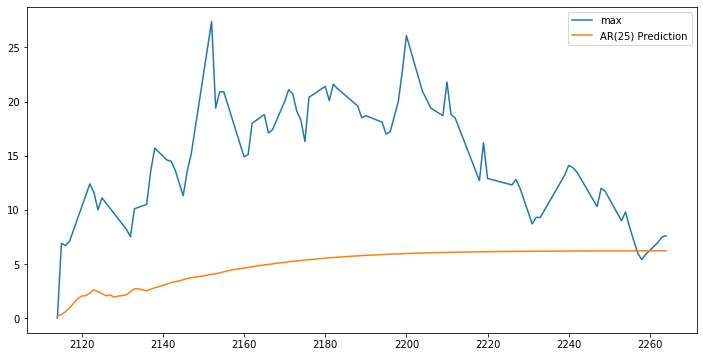

In [62]:
test_df[value_field].plot(legend=True)
ARprediction.plot(legend=True,figsize=(12,6));

AR failed completely. Not surprised!

#### Evaluating models

In [63]:
# Option 2: Use statsmodels implementations

from statsmodels.tools.eval_measures import mse, rmse, meanabs, aic, bic

In [64]:
mae = meanabs(test_df[value_field], ARprediction)

mae

9.822770692271247

In [65]:
# Akaike information criterion (AIC)
# we seldom compute AIC alone as it is built into many of the statsmodels tools we use

In [66]:
# Bayesian information criterion (BIC)
# we seldom compute BIC alone as it is built into many of the statsmodels tools we use

2. Pyramid ARIMA aka Auto-ARIMA

In [67]:
from pmdarima import auto_arima

In [68]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima``

In [89]:
stepwise_fit = auto_arima(full_df[value_field], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, 
                          m=2,#season_length,
                          start_P=0, 
                          seasonal=True,
                          d=None, 
                          D=1, 
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 2) (constant=True); AIC=7385.928, BIC=7414.550, Time=0.774 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=True); AIC=8784.156, BIC=8795.605, Time=0.046 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 2) (constant=True); AIC=7907.841, BIC=7930.739, Time=0.302 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 2) (constant=True); AIC=7396.183, BIC=7419.081, Time=0.679 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=False); AIC=8782.188, BIC=8787.913, Time=0.035 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 2) (constant=True); AIC=7384.513, BIC=7407.411, Time=0.822 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 0, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 2) (constant=True); A

In [90]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2265
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 2)   Log Likelihood               -3676.473
Date:                             Wed, 11 Mar 2020   AIC                           7364.946
Time:                                     01:05:15   BIC                           7399.293
Sample:                                          0   HQIC                          7377.479
                                            - 2265                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.989      0.323      -0.000       0.000
ar.L1          0.9666      0.005    192.599      0.000       0.957       0.976
ar.S.L2        0.0089      0.022      0.408      0.683      -0.034       0.052
ar.S.L4       -0.0135      0.021     -0.655      0.512      -0.054       0.027
ma.S.L2       -0.9995      0.010   -105.161      0.000      -1.018      -0.981
sigma2         1.4995      0.013    112.741      0.000       1.473       1.526
===================================================================================
Ljung-Box (Q):                       81.07   Jarque-Bera (JB):            372366.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [72]:
# apply the first different
from statsmodels.tsa.statespace.tools import diff

In [73]:
diff1_df = diff(full_df[value_field], k_diff=1)

In [74]:
diff1_df.head()

1   0.10000
2   0.00000
3   0.10000
4   0.10000
5   0.20000
Name: max, dtype: float64

In [75]:
adf_test(diff1_df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -18.18627
p-value                    0.00000
# lags used               10.00000
# observations         2,253.00000
critical value (1%)       -3.43326
critical value (5%)       -2.86282
critical value (10%)      -2.56745
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [76]:
# fit model
model = ARIMA(train_df[value_field], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.max   No. Observations:                 2113
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3391.026
Method:                       css-mle   S.D. of innovations              1.204
Date:                Tue, 10 Mar 2020   AIC                           6790.053
Time:                        23:16:01   BIC                           6812.676
Sample:                             1   HQIC                          6798.336
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.017      0.040      0.968      -0.032       0.034
ar.L1.D.max     0.7677      0.044     17.256      0.000       0.680       0.855
ma.L1.D.max    -0.8508      0.036    -23.828      0.000      -0.921      -0.781
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3027           +0.0000j            1.3027            0.0000
MA.1            1.1754           +0.0000j            1.1754            0.0000
-----------------------------------------------------------------------------
"""

In [78]:
# predict
predictions = results.predict(start=start, end=end,
                              dynamic=False,
                              typ='levels'  # linear: return in differences; levels: return in original form
                              ).rename('ARIMA(1,1,1) Predictions')

In [79]:
predictions.head()

2114   0.43144
2115   0.75513
2116   1.00376
2117   1.19479
2118   1.34159
Name: ARIMA(1,1,1) Predictions, dtype: float64

In [80]:
predictions.tail()

2260   1.92027
2261   1.92094
2262   1.92162
2263   1.92229
2264   1.92297
Name: ARIMA(1,1,1) Predictions, dtype: float64

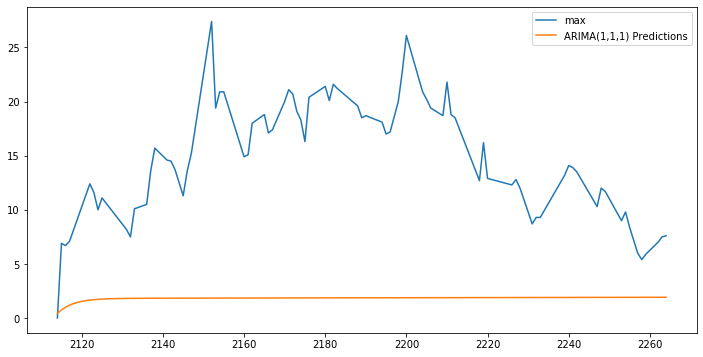

In [81]:
# plot
test_df[value_field].plot(legend=True)
predictions.plot(legend=True,figsize=(12,6));

In [82]:
# forecast future
model = ARIMA(full_df[value_field], order=(1,1,1))
results = model.fit()

In [86]:
forecast = results.predict(start=len(full_df), end=len(full_df) + season_length, 
                         typ='levels').rename('ARIMA(1,1,1) Forecasts')

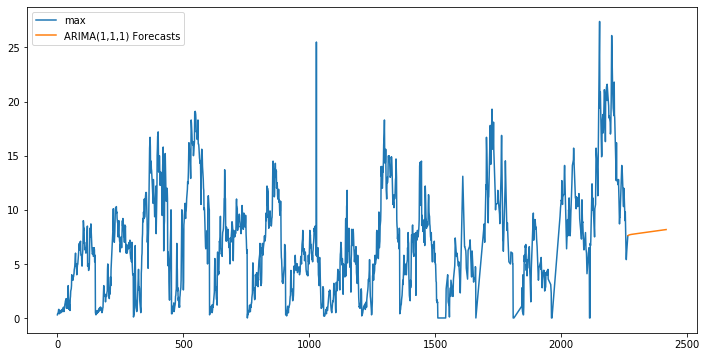

In [87]:
full_df[value_field].plot(legend=True)
forecast.plot(legend=True,figsize=(12,6));

3. Seasonal ARIMA

In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
model = SARIMAX(train_df[value_field],order=(1,0,0),seasonal_order=(2,1,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 max   No. Observations:                 2114
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 2)   Log Likelihood               -3392.492
Date:                             Wed, 11 Mar 2020   AIC                           6794.985
Time:                                     01:06:06   BIC                           6823.262
Sample:                                          0   HQIC                          6805.339
                                            - 2114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9622      0.005    212.246      0.000       0.953       0.971
ar.S.L2        0.0005      0.023      0.023      0.982      -0.045       0.046
ar.S.L4       -0.0093      0.022     -0.425      0.671      -0.052       0.034
ma.S.L2       -1.0000      0.154     -6.511      0.000      -1.301      -0.699
sigma2         1.4467      0.217      6.660      0.000       1.021       1.872
===================================================================================
Ljung-Box (Q):                       75.48   Jarque-Bera (JB):            441263.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
predictions = results.predict(start=start, end=end, 
                              dynamic=False,  # dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values). 
                              typ='levels'  # typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables
                             ).rename('SARIMA(1,0,0)(2,1,1,2) Predictions')

In [93]:
predictions.head()

2114   0.26109
2115   0.47215
2116   0.76565
2117   0.95540
2118   1.17481
Name: SARIMA(1,0,0)(2,1,1,2) Predictions, dtype: float64

In [94]:
predictions.tail()

2260   6.23438
2261   6.21543
2262   6.23597
2263   6.21696
2264   6.23744
Name: SARIMA(1,0,0)(2,1,1,2) Predictions, dtype: float64

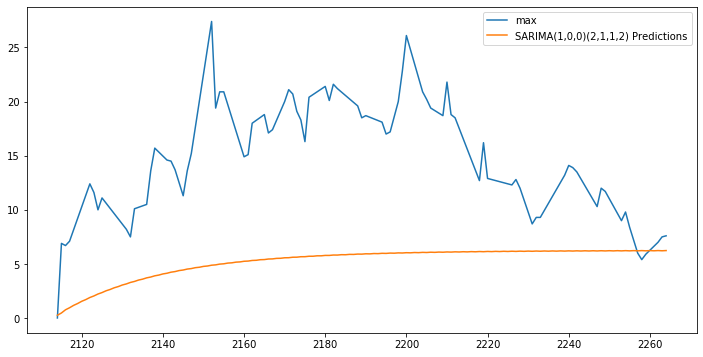

In [95]:
test_df[value_field].plot(legend=True)
predictions.plot(legend=True,figsize=(12,6));